# Analyzing spiking responses to visual stimuli

In this notebook, you will engage in some exploratory data analysis of one of Frank's recording sessions, the same one we used for our spike sorting exercise this morning.

This is a recording from area V2 in tree shrew visual cortex. Not a lot has been published about the neurons in this area. The recording contains responses to several kinds of visual stimuli as well as to electrical stimuli delivered to V1.

The point of the exercise is not to reach a scientific conclusion. (After all, this is *N* = 1 recording), but rather to try a few different analytic approaches and see if you can come up with some preliminary ideas about what this neurons in tree shrew V2 are all about. This exercise is intentionally open-ended. We encourage you to try alternative approaches.

## Accessing the data

First, we need to access the data. This morning, we already accessed the raw traces for this experiment, now we will also open the KiloSort 2.0 spike data. If you decided you like one of the other sorters better, you can absolutely use its results instead. (In the "Sorted" notebook, you can see how to extract the spike trains.)

In [1]:
%pip install  ephysio
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ephysio: filename=ephysio-1.0.7-py3-none-any.whl size=41552 sha256=7d0f723b08c330eb5a7700e31ce09f014042b63b52ac9c0f476cc3f07b973978
  Stored in directory: /root/.cache/pip/wheels/89/0d/fc/2ed758c3bae490a367256cc1ed09eb174df2e786e467269ecb
Successfully built ephysio
Mounted at /content/drive


In [2]:
from ephysio import openEphysIO
from ephysio import kilosortIO
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt

In [3]:
root = "/content/drive/MyDrive/datasai-daw/data/2021-07-20_11-59-01"
oe = openEphysIO.Loader(root)

In [4]:
oe.spikestreams()

['Neuropix-PXI-111.0']

In [5]:
ks = kilosortIO.Reader(oe.contfolder(oe.spikestream(), rec=9) + "/kilosort20_output")

Using cluster group labels from phy2 to override ks labels


Frank stores metadata about each recording in JSON files with the experimental data. This is a very convenient way to make sure you don't have to rely on memory for knowing which binary channel in the recording carries which signal:

In [6]:
with open(f"{root}/exptINFO_2021-07-20_11-59-01+9.json") as fd:
    info = json.load(fd)
info

{'root': 'F:/antidromic_project/experiments/2021-07-20_11-59-01',
 'rec': 9,
 'fs_Hz': 30000,
 'nidaq': 'NI-DAQmx-121.0',
 'probes': ['Neuropix-PXI-111.0'],
 'ttls': [1],
 'bnc': [2],
 'visbnc': [4, 3],
 't_split_s': 20,
 'kilosort': ['kilosort20_output'],
 'areas': ['V2 left'],
 'stimareas': ['V1 left'],
 'name': ['Lakers'],
 'notes': '',
 'microstimuli': {'0': ['boatload', 400, 1900],
  '1': ['ramptest', [100, 10, 450], 1900]},
 'visualstimuli': {'0': ['0_PLAYER_EPHYS_binoc_sparse_noise_highRes.py',
   'EPHYS_binoc_sparse_noise_highResX2.pkl',
   1900],
  '1': ['1_PLAYER_EPHYS_binoc_static_gratings.py',
   'EPHYS_binoc_static_gratings.pkl',
   1900],
  '2': ['2_PLAYER_EPHYS_binoc_simoncelliTxt_10.py',
   'EPHYS_binoc_simoncelliTxt_10.pkl',
   1900],
  '3': ['3_playmovie_binoc_opticflow.sh', 'binoc_opticflow_movie.pkl', 1900]}}

We learn that the sync pulses for electrical stimuli can be found on digital channel 2, whereas the sync pulses for visual stimuli can be found on digital channel 4. We also see that there are two blocks of electrical stimuli, one of type "boatload", and one of type "ramptest". (Ask Frank to show you the detailed log files to see exactly what that means.) And we see that there were four blocks of visual stimuli. The record shows the names of the python scripts that controlled those stimuli, and the name of "pickle" files that store the detailed parameters. We will access those in a little bit.

Let's first extract the time stamps of the state transitions on the digital channels, so we can find out when exactly the stimuli occurred:

In [7]:
evts = oe.nidaqevents(oe.spikestream(), rec=9)

(Found 501 legit bar codes and 25 other groups)
(Found 501 legit bar codes and 25 other groups)


Do we actually have channels 2 and 4?

In [8]:
evts.keys()

dict_keys([2, 3, 4])

Yes, we do.

Let's extract the timestamps of the electrical stimuli:

In [9]:
eblks = oe.inferblocks(evts[2], oe.spikestream())
len(eblks)

2

We have two blocks. Very good. How many stimuli per block?

In [10]:
[len(x) for x in eblks]

[600, 720]

Looks plausible.

Same for the visual stimuli:

In [11]:
vblks = oe.inferblocks(evts[4], oe.spikestream())
len(vblks)

4

Four blocks. Exactly as advertised.

In [12]:
[len(x.flatten()) for x in vblks]

[9216, 2460, 3900, 250]

In [13]:
vblks[0].shape

(4608, 2)

(Why does the counting of visual stimuli look different than of electrical stimuli? The answer is technical: The electrical stimuli are each marked by a short TTL pulse, whereas the visual stimuli are marked by a black-to-white or white-to-black transition of a little square on the corner of the display monitor, which gets picked up by a phototransistor. As a consequence, we only care about the 0-to-1 transitions of the electrical markers, but we care about both the 0-to-1 and the 1-to-0 transitions of the visual markers.)

To get you started, let's focus on the "gratings" stimulus block. This compromised multiple presentations of full-screen gratings, with 6 different orientations, 5 different spatial frequencies, and 4 different combinations of eye presentation (explained below).

The first step is to extract the stimulus time stamps, and to load the "pickle" that contains the relevant stimulus information.

In [14]:
tframe = vblks[1].flatten()
fn = f"{root}/visual_stimuli/{info['visualstimuli']['1'][1]}"
with open(fn, 'rb') as fd:
    pkl = pickle.load(fd)

So what information do we have?

In [15]:
pkl.keys()

dict_keys(['FPS', 'NREPS', 'F', 'structure', 'osp_idx', 'TGRAY', 'ORIENT', 'SPFREQ', 'PHASE', 'EYE', '__names__'])

By convention, variables with ALLCAPS names are constants. Let's educate ourselves.

In [16]:
for k, v in pkl.items():
    if k==k.upper():
      print(f"{k}: {v}")

FPS: 10
NREPS: 9
F: 120
TGRAY: 3
ORIENT: [0, 30, 60, 90, 120, 150]
SPFREQ: [0.1, 0.2, 0.4, 0.8, 1.6]
PHASE: [0]
EYE: [1, 2, 3, -1]


What this means, is that the images were presented at a rate of 10 frames per second, 9 repeats of each stimulus, total 120 different kinds of images, 3 s of gray at the beginning of the experiment, 6 orientations (0°, 30°, etc.), four spatial frequencies (0.1 cycles/degree, 0.2 cycles/degree, etc), one phase (i.e., Frank did not in this recording test whether translating the grating by a fraction of the period made a difference), and 4 "eye" combinations. These mean, respectively: image presented only to the right eye (1, contralateral to the recording site in left V2), only to the left eye (2, ipsilateral), to both eyes (3), or with a sensory conflict (-1). The sensory conflict meant that the right eye viewed the orientation specified, while the left eye viewed a stimulus that was 90° rotated.

How do we know which stimulus was presented when? That's encoded in the "osp_idx":

In [17]:
len(pkl['osp_idx'])

2460

In [18]:
tstim = []
ospe = []
for k, x in enumerate(pkl['osp_idx']):
    if x:
        tstim.append(tframe[k])
        ospe.append(x)
    # Else, this is a gray frame, which we will ignore for now.
tstim = np.array(tstim)
ospe = np.array(ospe)

In [19]:
tstim.shape

(1080,)

In [20]:
ospe.shape

(1080, 4)

### Exercise

Do these numbers make sense? We should have 9 repeats of 6 orientations x 5 spatial frequencies x 4 eye combinations.

In [21]:
# Insert your code here
9*6*5*4

1080

What's in the `ospe`?

In [22]:
ospe[:10]

array([[4, 4, 0, 1],
       [0, 1, 0, 3],
       [0, 4, 0, 2],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [5, 4, 0, 0],
       [2, 3, 0, 1],
       [4, 1, 0, 0],
       [2, 2, 0, 1],
       [2, 0, 0, 0]])

Conclusion, the first column represents the orientation (0 ⇒ 0°, 1 ⇒ 30°, etc), the second the spatial frequency, the fourth the eye (0 ⇒ right, 1 ⇒ left, 2 ⇒ both, 3 ⇒ conflict). The third column is boring.

### Exercise

Look at the first few numbers in the `tstim` vector, and guess whether they represent time stamps in seconds, milliseconds, or samples.

In [23]:
# Insert your code here
tstim[:10]

array([77367567, 77373567, 77379567, 77385568, 77391567, 77397566,
       77403567, 77409567, 77415567, 77421566])

In [24]:
np.diff(tstim[:10])/30000

array([0.2       , 0.2       , 0.20003333, 0.19996667, 0.19996667,
       0.20003333, 0.2       , 0.2       , 0.19996667])

As we saw earlier, KiloSort reports both "good" clusters (putative single-neuron clusters) and "mua" clusters (multi-unit activity). We will only analyze the former, as the "mua"-labeled clusters very poorly matched the other spike sorters, so we we don't trust them.

In [25]:
tspk = ks.spikesbycluster('good')

### Exercise

What is the container type of tspk? Why do you think the data are represented like that? What is the contained type? In what unit do you think spike times are stored?

In [26]:
# Insert your code here
type(tspk)

dict

In [27]:
len(tspk)

228

In [28]:
type(tspk[1])

numpy.ndarray

In [29]:
tspk[1].shape

(3545,)

In [30]:
tspk[1].dtype

dtype('uint64')

Let's convert all times to seconds, so we don't have to keep track of sampling rates from here on out.

In [31]:
fshz = oe.samplingrate(oe.spikestream())
tstim_s = tstim / fshz
tspk_s = { k: v / fshz for k, v in tspk.items() }

You can absolutely write your own code to align spike times to stimulus times and count per-stimulus responses, but there are many libraries that provide this functionality, so there is probably no need to reinvent the wheel. If you already have a favorite library, by all means use it. Otherwise, here is mine:

In [32]:
from ephysio.spikestats import SpikeStats

We feed it our stimulus times and dictionary of spike times:

In [33]:
ss = SpikeStats(tstim_s, tspk_s)

And now we can extract the latencies of any particular neuron's spikes relative to the stimuli. For example, let's look when neuron #1 fired relative to our stimuli:

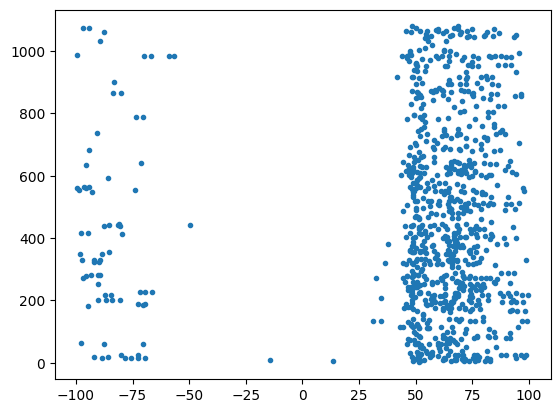

In [34]:
lat, tri = ss.latencies(1, -100, 100)
plt.plot(lat, tri, '.')

In [35]:
tspk.keys()

dict_keys([0, 1, 3, 4, 5, 6, 12, 14, 29, 34, 37, 38, 42, 43, 46, 49, 50, 51, 52, 53, 54, 58, 59, 60, 61, 63, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 80, 82, 84, 87, 88, 90, 94, 95, 97, 98, 100, 102, 107, 108, 110, 111, 112, 114, 118, 119, 121, 122, 123, 124, 127, 128, 130, 133, 137, 138, 139, 141, 145, 148, 151, 152, 155, 158, 161, 165, 166, 168, 170, 175, 180, 181, 182, 188, 192, 193, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 214, 215, 216, 217, 219, 221, 225, 226, 227, 228, 231, 237, 239, 240, 241, 242, 243, 245, 247, 249, 250, 251, 252, 253, 256, 257, 258, 259, 260, 261, 263, 268, 269, 270, 271, 272, 277, 293, 294, 295, 298, 299, 301, 302, 306, 311, 312, 314, 315, 316, 317, 318, 322, 337, 340, 360, 361, 364, 369, 371, 377, 383, 391, 395, 450, 454, 455, 457, 460, 461, 463, 466, 467, 469, 470, 472, 473, 475, 477, 483, 486, 488, 489, 490, 493, 495, 496, 498, 499, 502, 504, 506, 507, 508, 509, 510, 511, 512, 514, 515, 518, 524, 528, 531, 535, 536, 539, 558, 561

### Exercise: Does this look right?

Why did we plot time from -100 ms to +100 ms? Why do you think there are fewer spikes during the last 200 stimuli compared to the first 200? What could explain that there are more spikes between -100 ms and -75 ms than between -50 ms and -25 ms?

Look at a couple other units as well, to get a better feel for the data. (Remember: don't walk around with a blindfold on.) What else would you like to do to explore the raw spike data?

In [36]:
# Insert your code here


Let's count the number of spikes fired by neuron #1 in the first 100 ms after each stimulus:

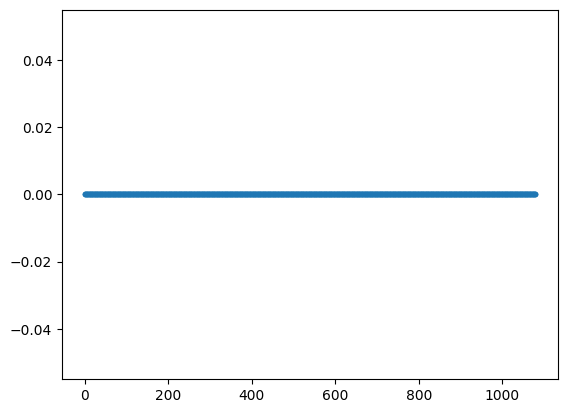

In [37]:
cnt = ss.spikecounts(1, 0, 100)
plt.plot(cnt, '.')

That cannot be right. The raster clearly showed plenty of spikes, yet we count nothing.

### Debugging time

Let's (for the moment) assume the library code is correct. Did we use it incorrectly?

In [38]:
ss.spikecounts?

Looks like we used the function correctly. What else could be wrong? Did we feed broken data into SpikeStats? Let's take a look:

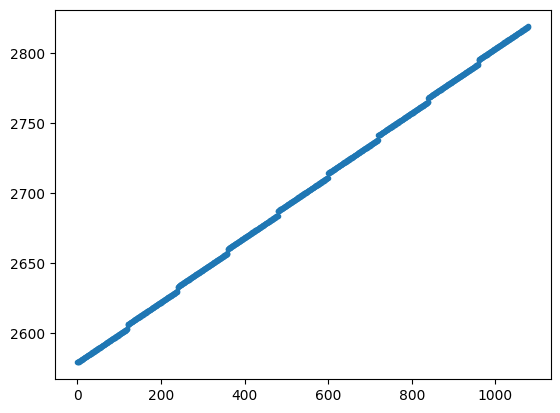

In [39]:
plt.plot(tstim_s, '.')

The stimulus times look plausible (nicely sequential, correct number, spanning a reasonable amount of time).

What about the spike times?

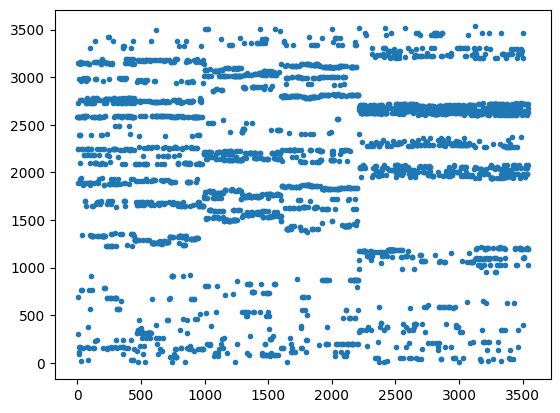

In [40]:
plt.plot(tspk_s[1], '.')

Those are not in order. Is that a problem?

In [41]:
SpikeStats?

It doesn't say. That's what you get for using homebrew libraries. But it's a good guess. Let's try sorting the spike times before feeding them in.

In [42]:
tspk_s = { k: np.sort(v) / fshz for k, v in tspk.items() }
ss = SpikeStats(tstim_s, tspk_s)

### Exercise

Did that solve the problem?

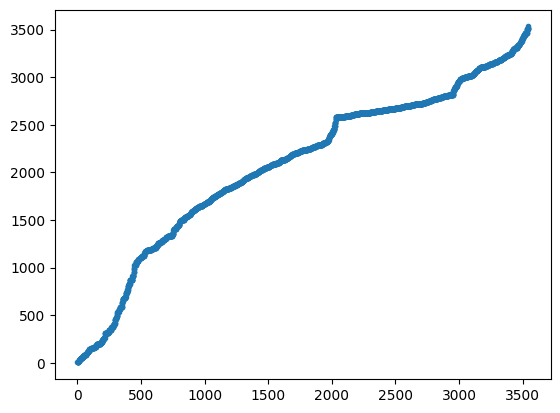

In [43]:
# Insert your code here
plt.plot(tspk_s[1], '.')

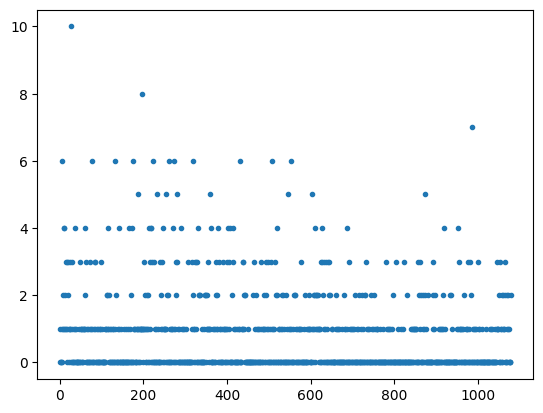

In [44]:
cnt = ss.spikecounts(1, 0, 100)
plt.plot(cnt, '.')

OK, it did. So now we can extract the responses for each of the cells. For instance:

In [45]:
cnts = {}
for celid in tspk_s.keys():
    cnts[celid] = ss.spikecounts(celid, 0, 100)
len(cnts), type(cnts[1]), cnts[1].shape

(228, numpy.ndarray, (1080,))

In [46]:
cnts = { celid: ss.spikecounts(celid, 0, 100) for celid in tspk_s.keys()}

So now we have 1080 response counts for each of 228 cells, stored in a dictionary of numpy arrays.

## Reshaping the data for further processing

For the sake of this exercise, we will feed these data into PCA to see whether the population differentiated between the various gratings we presented to the animal. Let's construct a PCA instance and remind ourselves what shape of data it wants.

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(10)
pca.fit?

So we need to present the data as a single array. In our case, the “features” are the neurons, and the “samples” are the stimuli. (I always have to think twice about that, so let's keep in mind that we need to check that we are doing it right.)

At the moment, the data are in a dictionary, so we need to repackage them as a single big array.

### Exercise

Extract a vector of cell IDs from the dictionary and a CxK array of the K stimulus responses of each of the C cells.

In [49]:
# Insert your code here
cellids = list(cnts.keys())
resps = np.array(list(cnts.values()))

In [50]:
resps.shape

(228, 1080)

In [51]:
resps.T.shape

(1080, 228)

In [52]:
cellids[:10]

[0, 1, 3, 4, 5, 6, 12, 14, 29, 34]

Now, we can feed the responses straight into the PCA:

In [53]:
pc = pca.fit_transform(resps.T)

### Exercise

What should the shape of the `pc` output be? Did we code that right? If not, can you fix it?

In [54]:
### Insert your code here
pc.shape

(1080, 10)

Let's see if orientation is captured in the first two principal components.

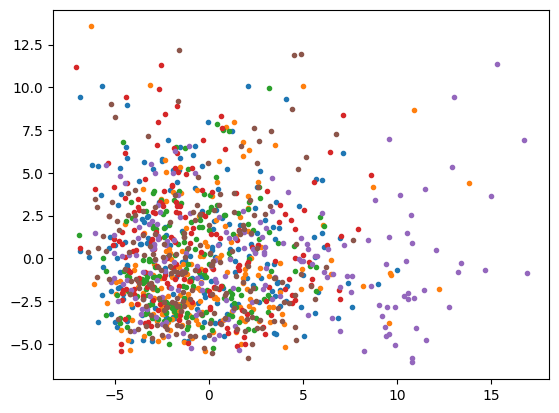

In [55]:
plt.figure()
for o in range(len(pkl["ORIENT"])):
  idx = np.nonzero(ospe[:,0]==o)[0]
  plt.plot(pc[idx,0], pc[idx,1], '.')

### Exercise

What do you think? Anything there?

Check out a few other PCs, perhaps?

In [56]:
# Insert your code here

def oplot(pcx=0, pcy=1):
  for o in range(len(pkl["ORIENT"])):
    idx = np.nonzero(ospe[:,0]==o)[0]
    plt.plot(pc[idx,pcx], pc[idx,pcy], '.')

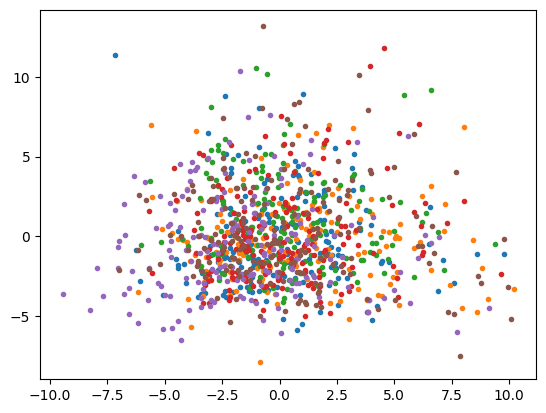

In [57]:
oplot(2,3)

In [58]:
1080*3/4

810.0

### Exercise

Is it a problem that we included the conflict stimuli? How can we avoid plotting those? Should we investigate left/right/both eye stimuli separately?

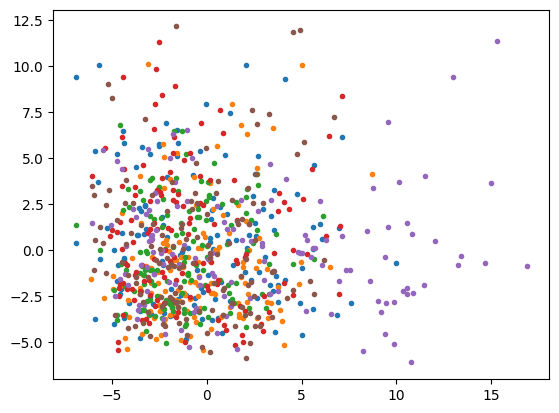

In [59]:
# Insert your code here

plt.figure()
for o in range(len(pkl["ORIENT"])):
  idx = np.nonzero(np.logical_and(ospe[:,0]==o, ospe[:,3]<3))[0]
  plt.plot(pc[idx,0], pc[idx,1], '.')

### Exercise

Make a similar plot, but use color to represent the different spatial frequencies.

*Hint:* Loop `for s in range len(pkl["SPFREQ"])`

In *this* case, are conflict stimuli equally problematic?

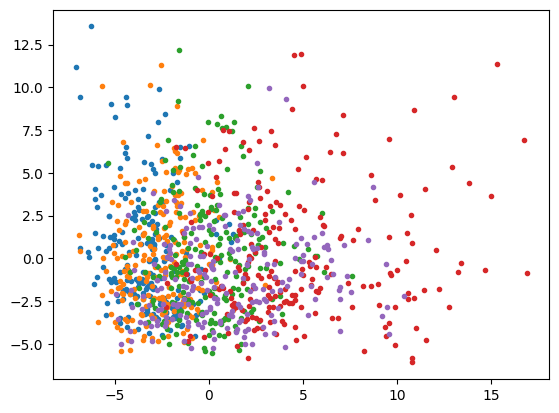

In [60]:
# Insert your code here
for s in range(len(pkl["SPFREQ"])):
   idx = np.nonzero(ospe[:,1]==s)[0]
   plt.plot(pc[idx,0], pc[idx,1], '.')

Do you agree that the population as a whole appears to respond differently to different spatial frequencies?

### Exercise

Make a simple bar plot of total population response as a function of spatial frequency. Do the results mesh with what the PCA indicated?

In [61]:
# Insert your code here

ss = SpikeStats(tstim_s, tspk_s, stim_idx=ospe)
ntri = ss.trialcounts()

In [62]:
nspk = []
for celid in tspk_s:
  n1 = ss.totalspikecountsbytrialtype(celid=celid, dt_start_ms=0, dt_end_ms=150)
  nspk.append(n1)
nspk = np.array(nspk)

In [63]:
nspk.shape, ntri.shape

((228, 6, 5, 1, 4), (6, 5, 1, 4))

In [64]:
ntri_by_sf = np.sum(ntri, axis=(0, 2, 3))
nspk_by_sf = np.sum(nspk, axis=(0, 1, 3, 4))

In [65]:
nspk_by_sf

array([32384, 34946, 37299, 37574, 33026])

<BarContainer object of 5 artists>

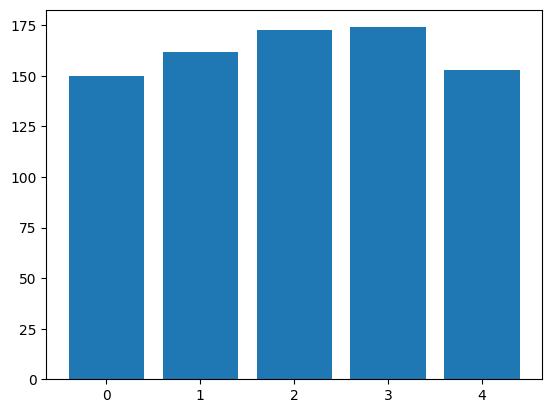

In [66]:
plt.bar(np.arange(5), nspk_by_sf/ntri_by_sf)

## The end is the beginning

From here, you could explore many follow-up ideas. For instance:

* Are there subpopulations that respond strongly to spatial frequencies that the area as a whole responds only weakly to? Nonnegative matrix factorization might be a starting point for exploring that.

* Are the responsive neurons concentrated in certain layers of the cortex? You can ask, for any unit, how far from the tip of the probe it sits with `ks.tipdist_unit`.

* Do different subpopulations respond more strongly to stimuli presented to one or the other eye?

* What are *you* curious about?

In [67]:
# Insert your code here...
SpikeStats.__dict__

mappingproxy({'__module__': 'ephysio.spikestats',
              '__init__': <function ephysio.spikestats.SpikeStats.__init__(self, stim_s, spks_s, stim_idx=None, selector=None)>,
              'latencies': <function ephysio.spikestats.SpikeStats.latencies(self, celid, dt_start_ms=-50, dt_end_ms=150)>,
              'spikecounts': <function ephysio.spikestats.SpikeStats.spikecounts(self, celid, dt_start_ms=-50, dt_end_ms=150)>,
              'psth': <function ephysio.spikestats.SpikeStats.psth(self, celid, dt_start_ms=-50, dt_end_ms=150, binsize_ms=5, pertrial=False)>,
              'ntrials': <function ephysio.spikestats.SpikeStats.ntrials(self)>,
              'trialcounts': <function ephysio.spikestats.SpikeStats.trialcounts(self)>,
              'totalspikecountsbytrialtype': <function ephysio.spikestats.SpikeStats.totalspikecountsbytrialtype(self, celid, dt_start_ms=-50, dt_end_ms=150)>,
              '__dict__': <attribute '__dict__' of 'SpikeStats' objects>,
              '__weak

In [68]:
ss.idx_shape = [6,5,1,4]